In [91]:
import pandas as pd
import pickle

DATA = 'assistments'
# DATA = 'robo'
CONTEXT = 'elo'
# CONTEXT = 'minimax'

def load_p(filename):
    with open(f'{filename}.pickle', 'rb') as f:
        return pickle.load(f)

backup = load_p(f'{DATA}-{CONTEXT}-new')

In [92]:
# backup['policies'][-1] = backup['policies'][-1][0]

In [93]:
backup['feedback']['position'] = backup['feedback']['position'].astype(int)

In [94]:
policy_names = [name for name, _ in backup['policies']]
policy_names

['Optimal IPW', 'GBDT', 'Behavior', 'Closestmiddle', 'Random', 'Optimal IRT']

In [95]:
policy_order = ['Optimal IPW', 'GBDT', 'Optimal IRT', 'Closestmiddle', 'Random', 'Behavior']
policy_title = {
    'Optimal IPW': 'Optimal IPW',
    'GBDT': 'Optimal GBDT',
    'Optimal IRT': 'Optimal IRT',
    'Closestmiddle': 'Closest to 50%',
    'Random': 'Random',
    'Behavior': 'Behavior policy'
}
if CONTEXT == 'minimax':
    policy_order.remove('Optimal IRT')
policy_order

['Optimal IPW', 'GBDT', 'Optimal IRT', 'Closestmiddle', 'Random', 'Behavior']

In [96]:

MINIMAX = ['min_context', 'max_context', 'prev_outcome']

# df = pd.read_csv('robo-minimax.csv')
# df.head()

In [97]:
# backup['feedback']['pscore'].max()

In [98]:
from obp.ope import (
    OffPolicyEvaluation,
    RegressionModel,
    InverseProbabilityWeighting as IPW,
    DirectMethod as DM,
    DoublyRobust as DR,
    SelfNormalizedInverseProbabilityWeighting as SNIPW,
    SwitchDoublyRobust as SDR,
)

ope = OffPolicyEvaluation(
    bandit_feedback=backup['feedback'],
    ope_estimators=[IPW(), DM(), DR(), SDR(), SNIPW()]
)

results = {}
for name, actions in backup['policies']:
    """ope.visualize_off_policy_estimates(
        action_dist=actions,
        estimated_rewards_by_reg_model=estimated_rewards_by_reg_model,
        n_bootstrap_samples=100
    )"""
    
    # Recompute pscores (no need)
    
    bundle = ope.summarize_off_policy_estimates(
        action_dist=actions,
        estimated_rewards_by_reg_model=backup['estimated_rewards_by_reg_model'],
        random_state=42
    )
    print(bundle)
    results[name] = bundle[1]
    print(results[name])
    print(ope.estimate_policy_values(
        action_dist=actions,
        estimated_rewards_by_reg_model=backup['estimated_rewards_by_reg_model'],
    ))
    print(f"^ {name}")

(           estimated_policy_value  relative_estimated_policy_value
ipw                      9.615910                         1.448814
dm                       8.387364                         1.263711
dr                       9.613630                         1.448470
switch-dr                9.613630                         1.448470
snipw                    9.615910                         1.448814,                mean  95.0% CI (lower)  95.0% CI (upper)
ipw        9.591253          9.265851          9.933844
dm         8.387616          8.382401          8.392696
dr         9.604341          9.493613          9.720135
switch-dr  9.604341          9.493613          9.720135
snipw      9.591253          9.265851          9.933844)
               mean  95.0% CI (lower)  95.0% CI (upper)
ipw        9.591253          9.265851          9.933844
dm         8.387616          8.382401          8.392696
dr         9.604341          9.493613          9.720135
switch-dr  9.604341          9.4936

In [99]:
import pandas as pd

LOWER = results['Optimal IPW'].columns[1]
UPPER = results['Optimal IPW'].columns[2]

results_df = pd.DataFrame()
for name in policy_order:
    results_df[name] = results[name]['mean']
    results_df[name + '_lower'] = results[name]['mean'] - results[name][LOWER]
    results_df[name + '_upper'] = results[name][UPPER] - results[name]['mean']
results_df

,Optimal IPW,Optimal IPW_lower,Optimal IPW_upper,GBDT,GBDT_lower,GBDT_upper,Optimal IRT,Optimal IRT_lower,Optimal IRT_upper,Closestmiddle,Closestmiddle_lower,Closestmiddle_upper,Random,Random_lower,Random_upper,Behavior,Behavior_lower,Behavior_upper
ipw,9.591253,0.325402,0.342591,8.819035,0.270277,0.359379,8.646032,0.332565,0.316655,6.365240,0.286612,0.325044,6.606349,0.024505,0.020932,6.637268,0.024535,0.017818
dm,8.387616,0.005214,0.005080,8.544824,0.005010,0.003908,8.516306,0.005044,0.004129,6.317400,0.003739,0.003085,6.618720,0.006514,0.005738,6.637490,0.005525,0.004738
dr,9.604341,0.110728,0.115794,8.793981,0.073597,0.107347,8.632485,0.115561,0.109700,6.465333,0.189202,0.152287,6.617187,0.022310,0.015401,6.637325,0.023348,0.016352
switch-dr,9.604341,0.110728,0.115794,8.793981,0.073597,0.107347,8.632485,0.115561,0.109700,6.465333,0.189202,0.152287,6.617187,0.022310,0.015401,6.637325,0.023348,0.016352
snipw,9.591253,0.325402,0.342591,8.831989,0.270674,0.359907,8.660504,0.333121,0.317185,6.477880,0.291684,0.330796,6.642973,0.024641,0.021048,6.637268,0.024535,0.017818


In [100]:
results_df[policy_order].round(3).T

,ipw,dm,dr,switch-dr,snipw
Optimal IPW,9.591,8.388,9.604,9.604,9.591
GBDT,8.819,8.545,8.794,8.794,8.832
Optimal IRT,8.646,8.516,8.632,8.632,8.661
Closestmiddle,6.365,6.317,6.465,6.465,6.478
Random,6.606,6.619,6.617,6.617,6.643
Behavior,6.637,6.637,6.637,6.637,6.637


In [88]:
upper_columns = [column + '_upper' for column in policy_order]
lower_columns = [column + '_lower' for column in policy_order]

In [89]:
pretty_data = {
    'robo': 'RoboMission',
    'assistments': 'Assistments',
    'elo': 'Elo-based',
    'minimax': 'minimax'
}

5 5 5
5 5 5


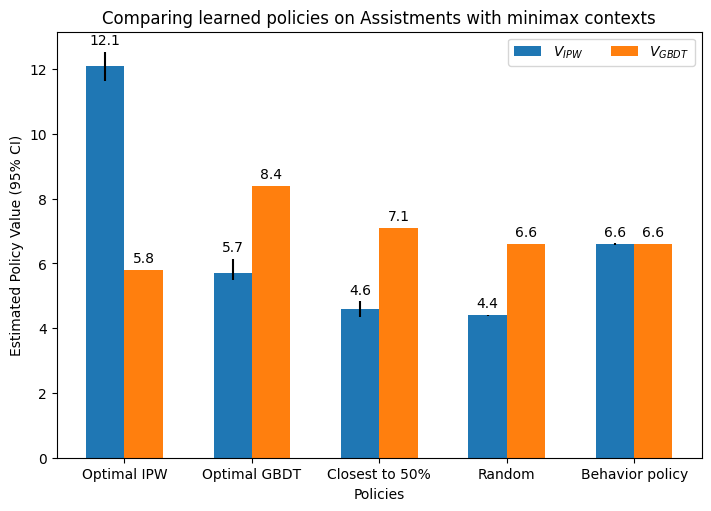

In [90]:
import numpy as np
import matplotlib.pyplot as plt

x = np.arange(len(policy_order))  # the label locations
width = 0.3  # the width of the bars
multiplier = 0

fig, ax = plt.subplots(layout='constrained', figsize=(7, 5))

pretty_name = {
    'ipw': '$V_{IPW}$',
    'dm': '$V_{GBDT}$',
    # 'dr': '$V_{C}$',
    # 'switch-dr': '$V_{SDR}$',
    # 'snipw': '$V_{SNIPW}$'
}

for name in results_df.index:
    if name in pretty_name:
        offset = width * multiplier
        measurement = results_df.loc[name, policy_order]
        print(len(x), len(measurement), len(lower_columns))
        rects = ax.bar(x + offset, measurement.round(1), width, label=pretty_name[name], yerr=np.stack(
            (results_df.loc[name, lower_columns], results_df.loc[name, upper_columns])))
        ax.bar_label(rects, padding=3)
        multiplier += 1

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Estimated Policy Value (95% CI)')
ax.set_xlabel('Policies')
ax.set_title(f'Comparing learned policies on {pretty_data[DATA]} with {pretty_data[CONTEXT]} contexts')
ax.set_xticks(x + width / 2, [policy_title[name] for name in policy_order])
ax.legend(loc='upper right', ncols=3)
# ax.set_ylim(0, 250)

# DATA = 'assistments-minimax'

plt.style.use('default')
plt.savefig(f'{DATA}-{CONTEXT}-new.pdf')
plt.savefig(f'{DATA}-{CONTEXT}-new.png')
plt.show()

In [25]:
backup['policies'][2][0]

'GBDT'

In [26]:
backup['policies'][1][0]

'Optimal IPW'

In [28]:
backup['policies'][3][0]

'Behavior'

In [85]:
backup['policies'][3][1].shape

(285811, 85, 1)

In [87]:
backup['feedback']['reward']

array([1.46922815, 1.19121064, 1.63080714, ..., 0.79034666, 2.10888898,
       0.        ])

In [96]:
backup['estimated_rewards_by_reg_model'][np.arange(285811), list(backup['feedback']['action'])]

array([[1.28346014],
       [1.05550308],
       [1.63085876],
       ...,
       [0.79065646],
       [2.06861405],
       [3.41515893]])

In [78]:
backup['feedback']['context'].max()

6.5

In [63]:
backup['feedback']['pscore'].shape

(285811,)

In [83]:
backup['feedback']['action']

array([ 5,  3,  6, ...,  1,  9, 12])

In [109]:
((backup['policies'][2][1][np.arange(285811), backup['feedback']['action']].squeeze() * backup['feedback']['reward']) / backup['feedback']['pscore']).mean()

3.3027355111610857

In [81]:
((backup['policies'][2][1] * backup['estimated_rewards_by_reg_model']).sum(axis=2).sum(axis=1) / backup['feedback']['pscore']).mean()

264.14372171684585

In [97]:
((backup['policies'][2][1][backup['feedback']['action']] * backup['feedback']['reward']).sum(axis=2).sum(axis=1) / backup['feedback']['pscore']).mean()

MemoryError: Unable to allocate 50.5 TiB for an array with shape (285811, 85, 285811) and data type float64

In [61]:
backup['policies'][2][1] / backup['feedback']['pscore']

MemoryError: Unable to allocate 50.5 TiB for an array with shape (285811, 85, 285811) and data type float64

In [35]:
values = np.nan_to_num(backup['policies'][2][1] / backup['policies'][3][1] * backup['estimated_rewards_by_reg_model'])
values.min()

/tmp/ipykernel_42561/1291607295.py:1: RuntimeWarning: divide by zero encountered in divide
  values = np.nan_to_num(backup['policies'][2][1] / backup['policies'][3][1] * backup['estimated_rewards_by_reg_model'])
/tmp/ipykernel_42561/1291607295.py:1: RuntimeWarning: invalid value encountered in divide
  values = np.nan_to_num(backup['policies'][2][1] / backup['policies'][3][1] * backup['estimated_rewards_by_reg_model'])


0.0

In [50]:
values.max()

1.7976931348623157e+308

In [55]:
values.sum(axis=1)

array([[3.06114051e+004],
       [3.06114051e+004],
       [1.79769313e+308],
       ...,
       [1.79769313e+308],
       [1.79769313e+308],
       [4.30119009e+004]])

In [48]:
backup['policies'][2][1][209, 25] / backup['policies'][3][1][209, 25]

/tmp/ipykernel_42561/2403510127.py:1: RuntimeWarning: divide by zero encountered in divide
  backup['policies'][2][1][209, 25] / backup['policies'][3][1][209, 25]


array([inf])

In [46]:
list(zip(range(1000), backup['policies'][2][1][209], backup['policies'][3][1][209]))

[(0, array([0.]), array([0.])),
 (1, array([0.]), array([0.])),
 (2, array([0.]), array([0.03225806])),
 (3, array([0.]), array([0.03225806])),
 (4, array([0.]), array([0.09677419])),
 (5, array([0.]), array([0.])),
 (6, array([0.]), array([0.06451613])),
 (7, array([0.]), array([0.12903226])),
 (8, array([0.]), array([0.])),
 (9, array([0.]), array([0.12903226])),
 (10, array([0.]), array([0.12903226])),
 (11, array([0.]), array([0.16129032])),
 (12, array([0.]), array([0.09677419])),
 (13, array([0.]), array([0.])),
 (14, array([0.]), array([0.])),
 (15, array([0.]), array([0.])),
 (16, array([0.]), array([0.03225806])),
 (17, array([0.]), array([0.03225806])),
 (18, array([0.]), array([0.])),
 (19, array([0.]), array([0.])),
 (20, array([0.]), array([0.])),
 (21, array([0.]), array([0.])),
 (22, array([0.]), array([0.])),
 (23, array([0.]), array([0.])),
 (24, array([0.]), array([0.06451613])),
 (25, array([1.]), array([0.])),
 (26, array([0.]), array([0.])),
 (27, array([0.]), arra

array([[0.        ],
       [0.        ],
       [0.03225806],
       [0.03225806],
       [0.09677419],
       [0.        ],
       [0.06451613],
       [0.12903226],
       [0.        ],
       [0.12903226],
       [0.12903226],
       [0.16129032],
       [0.09677419],
       [0.        ],
       [0.        ],
       [0.        ],
       [0.03225806],
       [0.03225806],
       [0.        ],
       [0.        ],
       [0.        ],
       [0.        ],
       [0.        ],
       [0.        ],
       [0.06451613],
       [0.        ],
       [0.        ],
       [0.        ],
       [0.        ],
       [0.        ],
       [0.        ],
       [0.        ],
       [0.        ],
       [0.        ],
       [0.        ],
       [0.        ],
       [0.        ],
       [0.        ],
       [0.        ],
       [0.        ],
       [0.        ],
       [0.        ],
       [0.        ],
       [0.        ],
       [0.        ],
       [0.        ],
       [0.        ],
       [0.   

In [40]:
values[209]

array([[0.00000000e+000],
       [0.00000000e+000],
       [0.00000000e+000],
       [0.00000000e+000],
       [0.00000000e+000],
       [0.00000000e+000],
       [0.00000000e+000],
       [0.00000000e+000],
       [0.00000000e+000],
       [0.00000000e+000],
       [0.00000000e+000],
       [0.00000000e+000],
       [0.00000000e+000],
       [0.00000000e+000],
       [0.00000000e+000],
       [0.00000000e+000],
       [0.00000000e+000],
       [0.00000000e+000],
       [0.00000000e+000],
       [0.00000000e+000],
       [0.00000000e+000],
       [0.00000000e+000],
       [0.00000000e+000],
       [0.00000000e+000],
       [0.00000000e+000],
       [1.79769313e+308],
       [0.00000000e+000],
       [0.00000000e+000],
       [0.00000000e+000],
       [0.00000000e+000],
       [0.00000000e+000],
       [0.00000000e+000],
       [0.00000000e+000],
       [0.00000000e+000],
       [0.00000000e+000],
       [0.00000000e+000],
       [0.00000000e+000],
       [0.00000000e+000],
       [0.00